In [10]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\la7tim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\la7tim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\la7tim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            # Split label and question
            label, question = line.strip().split(' ', 1)
            data.append({"question": question, "label": label})
    return pd.DataFrame(data)

train_set = load_data(".\data\\train_set5.txt")
test_set = load_data(".\data\\test_set.txt")

print(train_set.head())


                                            question        label
0  How did serfdom develop in and then leave Russ...  DESC:manner
1   What films featured the character Popeye Doyle ?  ENTY:cremat
2  How can I find a list of celebrities ' real na...  DESC:manner
3  What fowl grabs the spotlight after the Chines...  ENTY:animal
4                    What is the full form of .com ?     ABBR:exp


In [12]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define stop words and ensure WH-questions are retained
stop_words = set(stopwords.words('english'))
wh_questions = {"what", "where", "who", "when", "why", "how"}  # WH-questions
stop_words -= wh_questions  # Remove WH-questions from the stop words set

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    words = word_tokenize(text)
    # Filter stop words (excluding WH-questions)
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    # Rejoin words into a single string
    return ' '.join(words)

# Apply preprocessing to training and test sets
train_set['processed_question'] = train_set['question'].apply(preprocess_text)
test_set['processed_question'] = test_set['question'].apply(preprocess_text)


In [13]:
train_set[['category', 'specific_type']] = train_set['label'].str.split(':', expand=True)
test_set[['category', 'specific_type']] = test_set['label'].str.split(':', expand=True)

print(train_set[['label', 'category', 'specific_type']].head())


         label category specific_type
0  DESC:manner     DESC        manner
1  ENTY:cremat     ENTY        cremat
2  DESC:manner     DESC        manner
3  ENTY:animal     ENTY        animal
4     ABBR:exp     ABBR           exp


In [14]:
category_encoder = LabelEncoder()
specific_type_encoder = LabelEncoder()

train_set['category_encoded'] = category_encoder.fit_transform(train_set['category'])
train_set['specific_type_encoded'] = specific_type_encoder.fit_transform(train_set['specific_type'])

test_set['category_encoded'] = category_encoder.transform(test_set['category'])
test_set['specific_type_encoded'] = specific_type_encoder.transform(test_set['specific_type'])

print(train_set[['category', 'specific_type', 'category_encoded', 'specific_type_encoded']].head())


  category specific_type  category_encoded  specific_type_encoded
0     DESC        manner                 1                     23
1     ENTY        cremat                 2                      8
2     DESC        manner                 1                     23
3     ENTY        animal                 2                      1
4     ABBR           exp                 0                     16


In [15]:
train_set['combined_label'] = train_set['category'] + "_" + train_set['specific_type']
test_set['combined_label'] = test_set['category'] + "_" + test_set['specific_type']

combined_label_encoder = LabelEncoder()
train_set['combined_label_encoded'] = combined_label_encoder.fit_transform(train_set['combined_label'])
test_set['combined_label_encoded'] = combined_label_encoder.transform(test_set['combined_label'])

print(train_set[['combined_label', 'combined_label_encoded']].head())


  combined_label  combined_label_encoded
0    DESC_manner                       4
1    ENTY_cremat                       9
2    DESC_manner                       4
3    ENTY_animal                       6
4       ABBR_exp                       1


In [16]:
train_set.head()

,question,label,processed_question,category,specific_type,category_encoded,specific_type_encoded,combined_label,combined_label_encoded
0,How did serfdom develop in and then leave Russ...,DESC:manner,how serfdom develop leave russia,DESC,manner,1,23,DESC_manner,4
1,What films featured the character Popeye Doyle ?,ENTY:cremat,what film featured character popeye doyle,ENTY,cremat,2,8,ENTY_cremat,9
2,How can I find a list of celebrities ' real na...,DESC:manner,how find list celebrity real name,DESC,manner,1,23,DESC_manner,4
3,What fowl grabs the spotlight after the Chines...,ENTY:animal,what fowl grab spotlight chinese year monkey,ENTY,animal,2,1,ENTY_animal,6
4,What is the full form of .com ?,ABBR:exp,what full form com,ABBR,exp,0,16,ABBR_exp,1


In [18]:
# Get the length of each processed question
train_set['question_length'] = train_set['processed_question'].apply(lambda x: len(x.split()))

# Find the maximum length
max_len = train_set['question_length'].max()

print(f"Maximum length (max_len) of a question: {max_len}")


Maximum length (max_len) of a question: 21


In [25]:
y_train = train_set['combined_label_encoded']
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the processed questions (tokenizing the words)
tokenizer.fit_on_texts(train_set['processed_question'])

# Convert the questions to sequences (list of integers)
X_train = tokenizer.texts_to_sequences(train_set['processed_question'])
X_test = tokenizer.texts_to_sequences(test_set['processed_question'])

# Check the first few sequences
print(X_train[:5])


[[2, 3058, 1950, 700, 867], [1, 36, 511, 55, 1097, 3059], [2, 18, 354, 701, 242, 4], [1, 3060, 1951, 3061, 396, 14, 1428], [1, 457, 188, 3062]]


In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the maximum sequence length (you can adjust this)
max_len = 21

# Pad the sequences to make them all have the same length
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

# Check the shape of the padded data
print(f"Shape of X_train_padded: {X_train_padded.shape}")
print(f"Shape of X_test_padded: {X_test_padded.shape}")


Shape of X_train_padded: (5452, 21)
Shape of X_test_padded: (500, 21)


In [27]:
y_train = train_set['combined_label_encoded'].values
y_test = test_set['combined_label_encoded'].values

print(f"Shape of y_train: {y_train.shape}")


Shape of y_train: (5452,)


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the model architecture
model = Sequential()

# Add the embedding layer
# We use len(tokenizer.word_index) + 1 because word_index starts from 1
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len))

# LSTM layer for sequence modeling
model.add(LSTM(128, return_sequences=False))

# Add a Dropout layer to avoid overfitting
model.add(Dropout(0.5))

# Dense output layer
model.add(Dense(64, activation='relu'))

# Output layer: Multi-class classification (Softmax for multi-class)
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # len(np.unique(y_train)) is the number of classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train the model
history = model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_data=(X_test_padded, y_test))

# Save the trained model
model.save('lstm_model.h5')


Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6681 - loss: 1.0407 - val_accuracy: 0.5240 - val_loss: 2.5941
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7003 - loss: 0.9363 - val_accuracy: 0.5340 - val_loss: 2.6499
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7019 - loss: 0.9795 - val_accuracy: 0.3960 - val_loss: 2.6251
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7558 - loss: 0.7976 - val_accuracy: 0.4060 - val_loss: 2.8163
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7662 - loss: 0.7484 - val_accuracy: 0.5280 - val_loss: 2.6465
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8008 - loss: 0.6587 - val_accuracy: 0.5520 - val_loss: 2.9121
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8200 - loss: 0.5980 - val_accuracy: 0.5540 - val_loss: 2.9607
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8186 - loss: 0.5914 - val_accuracy: 0.5640 - v

In [31]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5793 - loss: 3.3661
Test Accuracy: 57.60%


In [32]:
# Predict on new data
predictions = model.predict(X_test_padded)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Decode the predicted labels back to original labels
predicted_labels_decoded = combined_label_encoder.inverse_transform(predicted_labels)

# Print the predictions for the first 10 test samples
for i in range(10):
    print(f"Question: {test_set['question'].iloc[i]}")
    print(f"Predicted Label: {predicted_labels_decoded[i]}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Question: How far is it from Denver to Aspen ?
Predicted Label: ENTY_body
Question: What county is Modesto , California in ?
Predicted Label: LOC_other
Question: Who was Galileo ?
Predicted Label: HUM_desc
Question: What is an atom ?
Predicted Label: DESC_desc
Question: When did Hawaii become a state ?
Predicted Label: NUM_date
Question: How tall is the Sears Building ?
Predicted Label: DESC_manner
Question: George Bush purchased a small interest in which baseball team ?
Predicted Label: DESC_def
Question: What is Australia 's national flower ?
Predicted Label: NUM_speed
Question: Why does the moon turn orange ?
Predicted Label: DESC_reason
Question: What is autism ?
Predicted Label: DESC_def


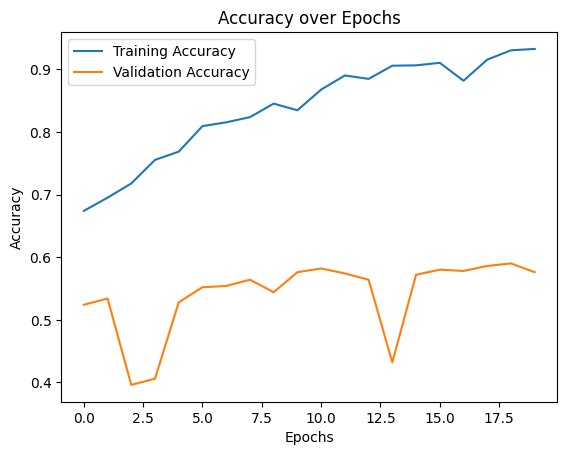

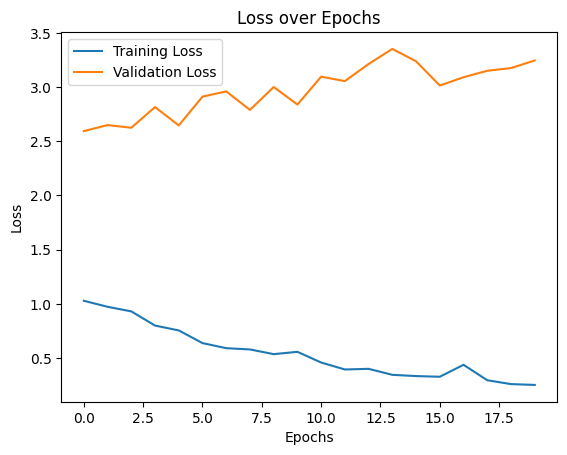

In [33]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the model architecture
model = Sequential()

# Add the embedding layer
# We use len(tokenizer.word_index) + 1 because word_index starts from 1
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len))

# Add the first LSTM layer
model.add(LSTM(128, return_sequences=True))

# Add a second LSTM layer
model.add(LSTM(64, return_sequences=False))

# Add a Dropout layer to avoid overfitting
model.add(Dropout(0.5))

# Add a Dense hidden layer
model.add(Dense(64, activation='relu'))

# Output layer: Multi-class classification (Softmax for multi-class)
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # len(np.unique(y_train)) is the number of classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_30 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Train the model
history = model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.1353 - loss: 3.5616 - val_accuracy: 0.1100 - val_loss: 3.3812
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.1745 - loss: 3.2353 - val_accuracy: 0.1280 - val_loss: 3.1467
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.2659 - loss: 2.7739 - val_accuracy: 0.3840 - val_loss: 2.5649
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.3736 - loss: 2.2754 - val_accuracy: 0.3960 - val_loss: 2.5125
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.4289 - loss: 1.9802 - val_accuracy: 0.4740 - val_loss: 2.4546
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.4907 - loss: 1.7609 - val_accuracy: 0.4840 - val_loss: 2.2864
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.5249 - loss: 1.6345 - val_accuracy: 0.5240 - val_loss: 2.2349
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.5632 - loss: 1.4704 - val_accuracy: 0.4780 - 

In [68]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5160 - loss: 2.8328
Test Accuracy: 50.40%


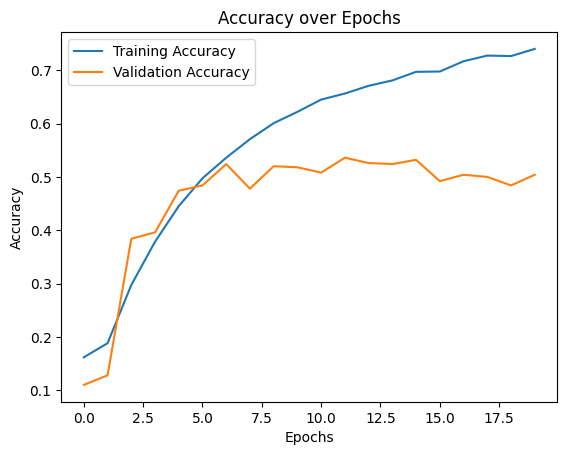

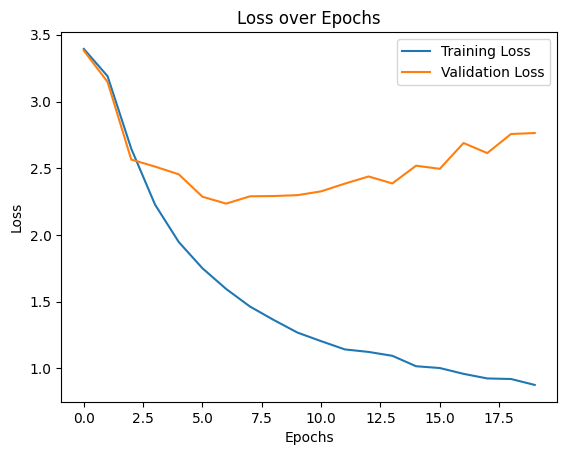

In [69]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [35]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_data=(X_test_padded, y_test), class_weight=class_weight_dict)


Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9621 - loss: 0.2755 - val_accuracy: 0.4660 - val_loss: 3.6517
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9685 - loss: 0.2108 - val_accuracy: 0.6080 - val_loss: 3.5324
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9329 - loss: 0.5346 - val_accuracy: 0.6200 - val_loss: 3.2783
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9601 - loss: 0.2535 - val_accuracy: 0.5960 - val_loss: 3.6202
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9580 - loss: 0.2550 - val_accuracy: 0.4440 - val_loss: 4.2232
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9546 - loss: 0.2137 - val_accuracy: 0.6200 - val_loss: 3.5679
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9727 - loss: 0.1454 - val_accuracy: 0.4860 - val_loss: 4.3401
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9830 - loss: 0.0869 - val_accuracy: 0.4600 - v

In [36]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5013 - loss: 4.6871
Test Accuracy: 48.80%


In [37]:
# Predict on new data
predictions = model.predict(X_test_padded)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Decode the predicted labels back to original labels
predicted_labels_decoded = combined_label_encoder.inverse_transform(predicted_labels)

# Print the predictions for the first 10 test samples
for i in range(10):
    print(f"Question: {test_set['question'].iloc[i]}")
    print(f"Predicted Label: {predicted_labels_decoded[i]}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Question: How far is it from Denver to Aspen ?
Predicted Label: NUM_dist
Question: What county is Modesto , California in ?
Predicted Label: LOC_other
Question: Who was Galileo ?
Predicted Label: HUM_desc
Question: What is an atom ?
Predicted Label: ABBR_exp
Question: When did Hawaii become a state ?
Predicted Label: NUM_date
Question: How tall is the Sears Building ?
Predicted Label: NUM_dist
Question: George Bush purchased a small interest in which baseball team ?
Predicted Label: NUM_date
Question: What is Australia 's national flower ?
Predicted Label: ENTY_plant
Question: Why does the moon turn orange ?
Predicted Label: DESC_reason
Question: What is autism ?
Predicted Label: DESC_desc


## fiw overfitting 

In [45]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

# Define the model architecture
model = Sequential()

# Add the embedding layer
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len))

# LSTM layer with L2 regularization
model.add(LSTM(64, return_sequences=False, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Add a Dropout layer to avoid overfitting
model.add(Dropout(0.6))  # Increased dropout rate

# Dense layer for intermediate representation
model.add(Dense(64, activation='relu'))

# Output layer: Multi-class classification (Softmax for multi-class)
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # len(np.unique(y_train)) is the number of classes

# Compile the model with a smaller learning rate
optimizer = Adam(learning_rate=0.0005)  # Lower learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()




Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_padded, y_train, epochs=50, batch_size=64, 
                    validation_data=(X_test_padded, y_test),
                    class_weight=class_weight_dict, 
                    callbacks=[early_stopping])

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0565 - loss: 3.9643 - val_accuracy: 0.1000 - val_loss: 3.9245
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0355 - loss: 3.8310 - val_accuracy: 0.0080 - val_loss: 3.9241
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0230 - loss: 4.0127 - val_accuracy: 0.0120 - val_loss: 3.9243
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0319 - loss: 3.8127 - val_accuracy: 0.0080 - val_loss: 3.9253
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0277 - loss: 3.8466 - val_accuracy: 0.0080 - val_loss: 3.9263
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0198 - loss: 4.0914 - val_accuracy: 0.0000e+00 - val_loss: 3.9252
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0131 - loss: 3.9038 - val_accuracy: 0.0080 - val_loss: 3.9248


In [49]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
import numpy as np

# Define the model architecture
model = Sequential()

# Add the embedding layer
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len))

# LSTM layer with L2 regularization (reduced complexity)
model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001)))  # Reduced LSTM units

# Add a Dropout layer to avoid overfitting
model.add(Dropout(0.3))  # Reduced dropout rate

# Dense layer for intermediate representation
model.add(Dense(64, activation='relu'))

# Output layer: Multi-class classification (Softmax for multi-class)
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # len(np.unique(y_train)) is the number of classes

# Compile the model with a smaller learning rate
optimizer = Adam(learning_rate=0.001)  # Try Adam with a higher learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_padded, y_train, epochs=100, batch_size=64, 
                    validation_data=(X_test_padded, y_test),
                    class_weight=class_weight_dict, 
                    callbacks=[early_stopping])


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0102 - loss: 4.0821 - val_accuracy: 0.0120 - val_loss: 3.9380
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0166 - loss: 3.8727 - val_accuracy: 0.0080 - val_loss: 3.9221
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0344 - loss: 3.8522 - val_accuracy: 0.0060 - val_loss: 3.9129
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0317 - loss: 3.9411 - val_accuracy: 0.0220 - val_loss: 3.9110
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0781 - loss: 3.5824 - val_accuracy: 0.0040 - val_loss: 3.6581
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0328 - loss: 3.4625 - val_accuracy: 0.0520 - val_loss: 3.5199
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0613 - loss: 3.2954 - val_accuracy: 0.2820 - val_loss: 3.3896
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1382 - loss: 3.2219 - val_accuracy: 0.0580 - 

## Use pretrained GloVe 64B

In [50]:
import numpy as np

# Function to load GloVe vectors
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index


In [51]:
def create_embedding_matrix(embedding_index, tokenizer, embedding_dim=50):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, idx in tokenizer.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
    return embedding_matrix


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

def create_model(embedding_matrix, embedding_dim, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))  # Freeze embeddings
    model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Adjust for multi-class
    
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Training with 50d GloVe embeddings...
Epoch 1/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0116 - loss: 4.6881 - val_accuracy: 0.0160 - val_loss: 4.2291
Epoch 2/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0244 - loss: 4.2717 - val_accuracy: 0.0080 - val_loss: 4.0035
Epoch 3/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0477 - loss: 4.0932 - val_accuracy: 0.0260 - val_loss: 3.7500
Epoch 4/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0366 - loss: 3.8144 - val_accuracy: 0.1900 - val_loss: 3.6726
Epoch 5/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0405 - loss: 3.7391 - val_accuracy: 0.2080 - val_loss: 3.7234
Epoch 6/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0493 - loss: 3.6492 - val_accuracy: 0.2200 - val_loss: 3.5585
Epoch 7/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0710 - loss: 3.5325 - val_accuracy: 0.2280 - val_loss: 3.5405
Epoch 8/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0730 - 

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


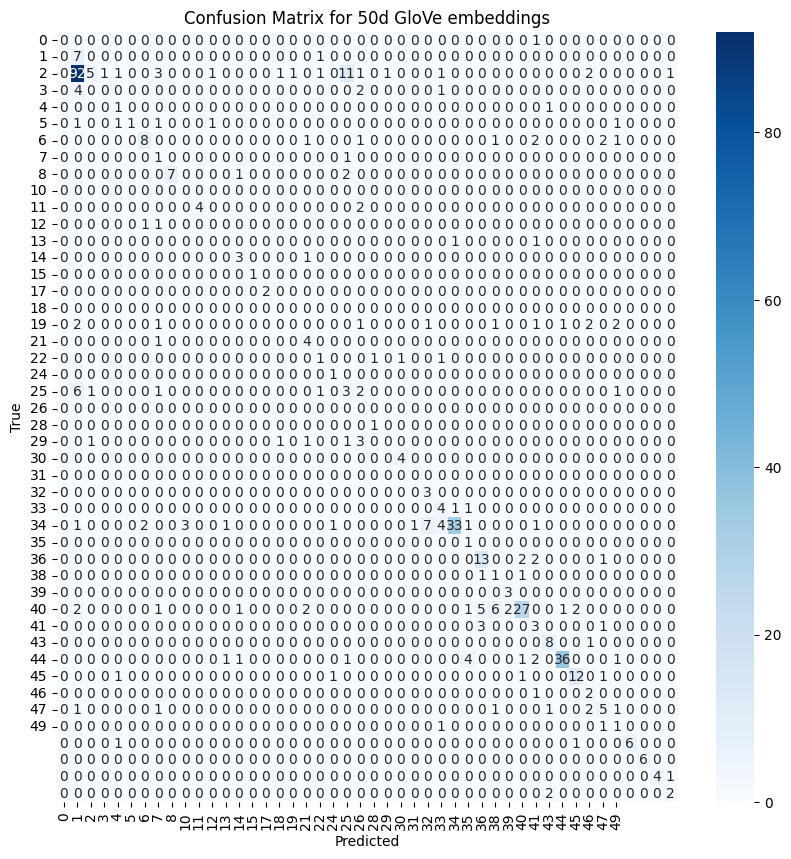

Training with 100d GloVe embeddings...
Epoch 1/300


c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0147 - loss: 5.0550 - val_accuracy: 0.0160 - val_loss: 4.4172
Epoch 2/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0336 - loss: 4.3567 - val_accuracy: 0.0080 - val_loss: 4.0287
Epoch 3/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0395 - loss: 3.8497 - val_accuracy: 0.0180 - val_loss: 3.7922
Epoch 4/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0347 - loss: 3.7260 - val_accuracy: 0.0540 - val_loss: 3.6680
Epoch 5/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0367 - loss: 3.6507 - val_accuracy: 0.2040 - val_loss: 3.6432
Epoch 6/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0400 - loss: 3.7021 - val_accuracy: 0.1940 - val_loss: 3.5823
Epoch 7/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0403 - loss: 3.6960 - val_accuracy: 0.1820 - val_loss: 3.5688
Epoch 8/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0366 - loss: 3.6047 - val_accuracy: 0.2100 - val_loss: 3.

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


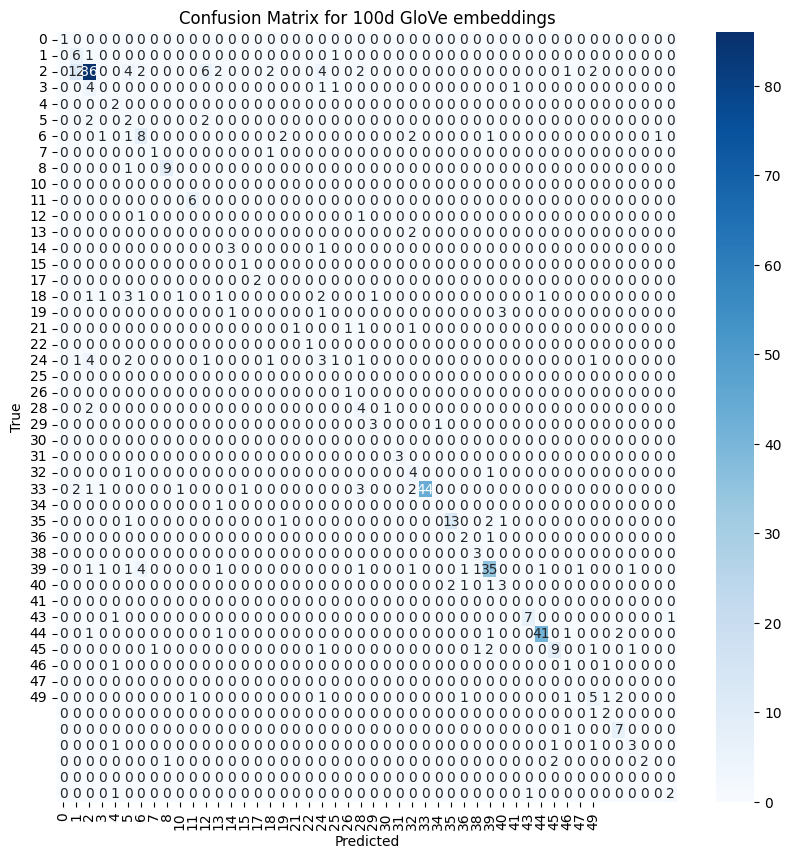

Training with 200d GloVe embeddings...
Epoch 1/300


c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0075 - loss: 5.9347 - val_accuracy: 0.0020 - val_loss: 4.5654
Epoch 2/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0283 - loss: 4.4007 - val_accuracy: 0.2520 - val_loss: 3.9658
Epoch 3/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0359 - loss: 4.2155 - val_accuracy: 0.0180 - val_loss: 3.7828
Epoch 4/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0335 - loss: 4.0675 - val_accuracy: 0.0260 - val_loss: 3.7313
Epoch 5/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0414 - loss: 3.6096 - val_accuracy: 0.0140 - val_loss: 3.6529
Epoch 6/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0343 - loss: 3.5400 - val_accuracy: 0.0120 - val_loss: 3.6194
Epoch 7/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0290 - loss: 3.5493 - val_accuracy: 0.0340 - val_loss: 3.6284
Epoch 8/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0398 - loss: 3.6061 - val_accuracy: 0.0280 - val_loss: 3.

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


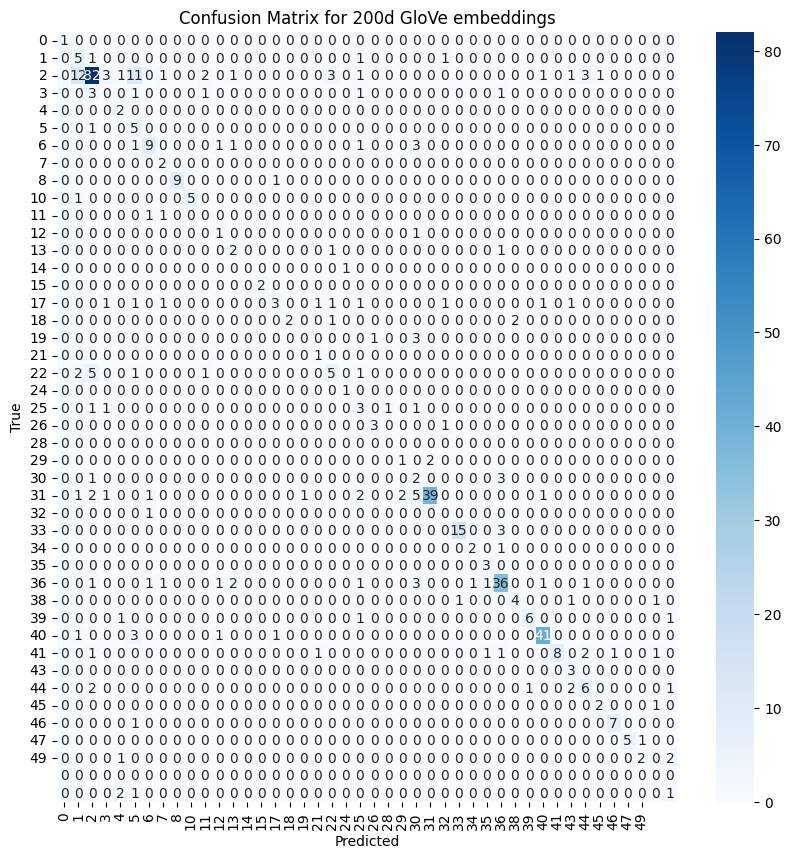

Training with 300d GloVe embeddings...
Epoch 1/300


c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0299 - loss: 5.8814 - val_accuracy: 0.0060 - val_loss: 4.6152
Epoch 2/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0286 - loss: 4.3844 - val_accuracy: 0.0060 - val_loss: 4.0451
Epoch 3/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0303 - loss: 3.9631 - val_accuracy: 0.0160 - val_loss: 3.7921
Epoch 4/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0585 - loss: 3.5098 - val_accuracy: 0.0400 - val_loss: 3.5719
Epoch 5/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0551 - loss: 3.4742 - val_accuracy: 0.0500 - val_loss: 3.3960
Epoch 6/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0620 - loss: 3.4073 - val_accuracy: 0.0500 - val_loss: 3.2719
Epoch 7/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0643 - loss: 3.2221 - val_accuracy: 0.0780 - val_loss: 3.3383
Epoch 8/300
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0661 - loss: 3.1587 - val_accuracy: 0.0860 - val_loss: 3.

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


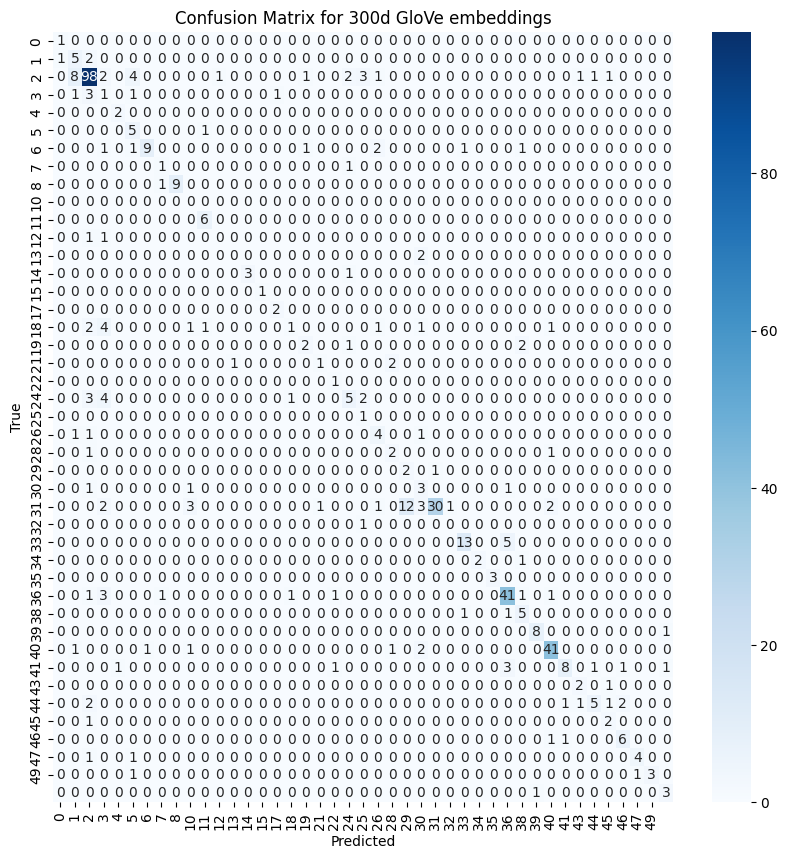

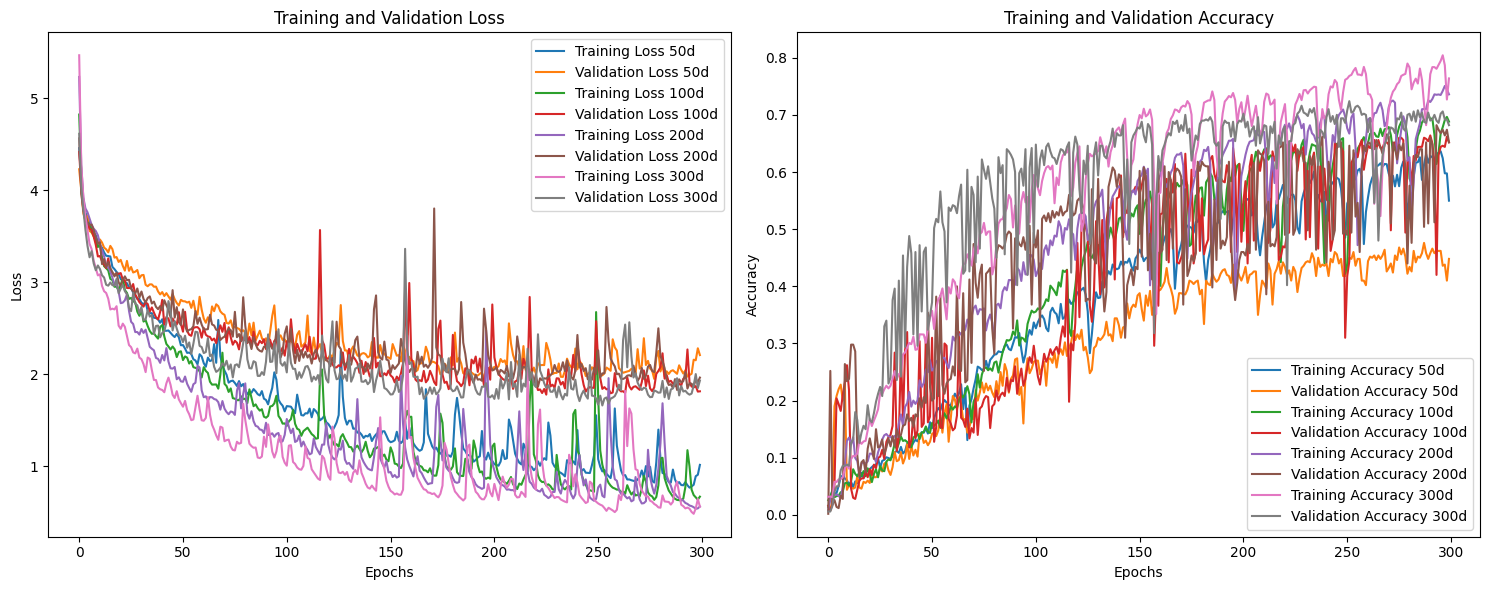

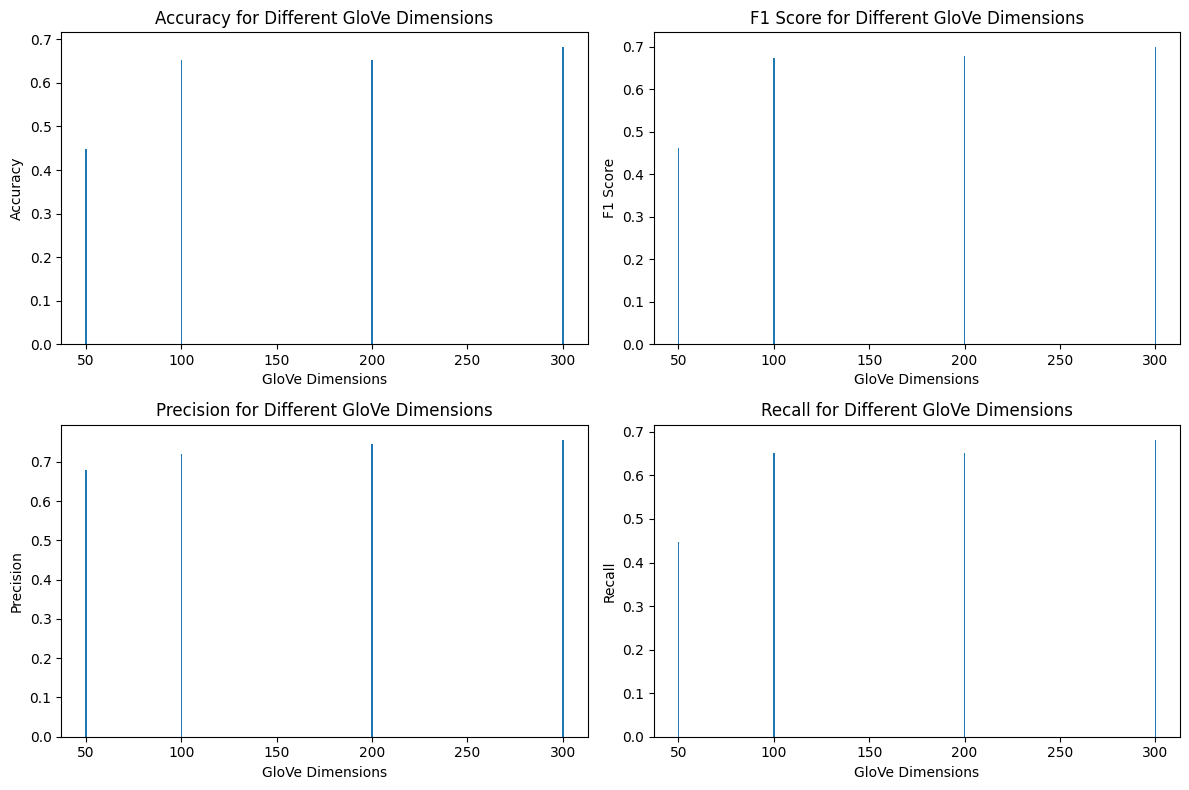


Metrics for 50d GloVe embeddings:
Accuracy: 0.4480
F1 Score: 0.4621
Precision: 0.6785
Recall: 0.4480

Metrics for 100d GloVe embeddings:
Accuracy: 0.6520
F1 Score: 0.6732
Precision: 0.7198
Recall: 0.6520

Metrics for 200d GloVe embeddings:
Accuracy: 0.6520
F1 Score: 0.6792
Precision: 0.7455
Recall: 0.6520

Metrics for 300d GloVe embeddings:
Accuracy: 0.6820
F1 Score: 0.6993
Precision: 0.7564
Recall: 0.6820


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

# List of GloVe files for different dimensions 
glove_files = {
    50: "C:\\Users\\la7tim\\Downloads\\glove.6B\\glove.6B.50d.txt",
    100: "C:\\Users\\la7tim\\Downloads\\glove.6B\\glove.6B.100d.txt",
    200: "C:\\Users\\la7tim\\Downloads\\glove.6B\\glove.6B.200d.txt",
    300: "C:\\Users\\la7tim\\Downloads\\glove.6B\\glove.6B.300d.txt"
}

# Initialize early stopping


# Initialize the history dictionary to store training histories
history_dict = {}
metrics_dict = {}

# Iterate over different dimensions
for dim, glove_file in glove_files.items():
    print(f"Training with {dim}d GloVe embeddings...")
    
    # Load GloVe embeddings
    embedding_index = load_glove_embeddings(glove_file)
    
    # Create the embedding matrix
    embedding_matrix = create_embedding_matrix(embedding_index, tokenizer, embedding_dim=dim)
    
    # Create and compile the model
    model = create_model(embedding_matrix, embedding_dim=dim, max_len=max_len)
    
    # Train the model and store the history
    history = model.fit(X_train_padded, y_train, epochs=300, batch_size=64, 
                        validation_data=(X_test_padded, y_test), 
                        class_weight=class_weight_dict)
    
    # Store the training history for the current dimension
    history_dict[dim] = history.history
    
    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test_padded, y_test)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")
    
    # Predict on the test set
    y_pred = np.argmax(model.predict(X_test_padded), axis=1)
    
    # Calculate the metrics
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Store metrics in the dictionary
    metrics_dict[dim] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    }
    
    # Generate Confusion Matrix and plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix for {dim}d GloVe embeddings')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plotting the training and validation loss for each GloVe dimension
plt.figure(figsize=(15, 6))

for dim, history in history_dict.items():
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label=f'Training Loss {dim}d')
    plt.plot(history['val_loss'], label=f'Validation Loss {dim}d')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label=f'Training Accuracy {dim}d')
    plt.plot(history['val_accuracy'], label=f'Validation Accuracy {dim}d')

# Set plot labels
plt.subplot(1, 2, 1)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Plot comparison of metrics across different GloVe dimensions
metrics_list = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
metric_values = {metric: [] for metric in metrics_list}

# Collect metric values for each GloVe dimension
for dim, metrics in metrics_dict.items():
    for metric in metrics_list:
        metric_values[metric].append(metrics[metric])

# Plotting the metrics for comparison
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics_list):
    plt.subplot(2, 2, i+1)
    plt.bar(metrics_dict.keys(), metric_values[metric])
    plt.title(f'{metric} for Different GloVe Dimensions')
    plt.xlabel('GloVe Dimensions')
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

# Print the evaluation results for each model
for dim, metrics in metrics_dict.items():
    print(f"\nMetrics for {dim}d GloVe embeddings:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


## glove 840B tokens

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Path to Common Crawl GloVe file (300d vectors, cased)
common_crawl_file = "C:\\Users\\la7tim\\Downloads\\glove.840B.300d\\glove.840B.300d.txt"

# Function to load GloVe embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Function to create embedding matrix
def create_embedding_matrix(embedding_index, tokenizer, embedding_dim=300):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, idx in tokenizer.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
    return embedding_matrix

# Function to create model
def create_model(embedding_matrix, embedding_dim, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))  # Freeze embeddings
    model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Adjust for multi-class
    
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            try:
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
            except ValueError:
                print(f"Skipping malformed line: {line.strip()}")
    return embeddings_index

# Load Common Crawl embeddings
print("Loading Common Crawl embeddings...")
embedding_index = load_glove_embeddings(common_crawl_file)





Loading Common Crawl embeddings...
Skipping malformed line: . . . -0.1573 -0.29517 0.30453 -0.54773 0.098293 -0.1776 0.21662 0.19261 -0.21101 0.53788 -0.047755 0.40675 0.023592 -0.32814 0.046858 0.19367 0.25565 -0.021019 -0.15957 -0.1023 0.20303 -0.043333 0.11618 -0.18486 0.0011948 -0.052301 0.34587 0.052335 0.16774 -0.21384 0.055947 0.24934 -0.12179 0.16749 0.28922 -0.033739 0.3015 -0.13241 0.092635 0.37155 -0.2884 -0.0052731 -0.001005 -0.51153 -0.28476 -0.20139 0.11837 -0.0055891 0.43604 0.16796 -0.2701 0.063957 -0.093253 -0.22079 0.36501 0.06545 0.23941 -0.19292 0.098293 0.12172 -0.1168 -0.027436 0.20507 -0.39139 -0.23111 0.46239 0.22888 -0.028415 -0.1798 0.23817 0.28093 -0.47935 0.23177 -0.35587 0.14246 0.11861 0.011018 0.091986 0.0054809 -0.39955 -0.40183 -0.10629 -0.30851 0.12383 -0.16737 -0.43569 0.4211 -0.57416 -0.19964 0.51312 0.090747 -0.21657 0.043519 0.24288 0.081134 0.49104 -0.33342 -0.31056 -0.3136 0.26931 -0.14402 0.33185 -0.21662 -0.072985 0.080603 -0.7266 -0.098385 -0.

Epoch 1/150


c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.1419 - loss: 5.8577 - val_accuracy: 0.1100 - val_loss: 4.1511
Epoch 2/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1703 - loss: 3.7499 - val_accuracy: 0.1100 - val_loss: 3.4002
Epoch 3/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1822 - loss: 3.1647 - val_accuracy: 0.2020 - val_loss: 3.1148
Epoch 4/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2494 - loss: 2.9208 - val_accuracy: 0.2140 - val_loss: 3.0434
Epoch 5/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2611 - loss: 2.8074 - val_accuracy: 0.4300 - val_loss: 2.8383
Epoch 6/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3102 - loss: 2.6327 - val_accuracy: 0.4680 - val_loss: 2.4841
Epoch 7/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3934 - loss: 2.3851 - val_accuracy: 0.4700 - val_loss: 2.3195
Epoch 8/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4262 - loss: 2.2259 - val_accuracy: 0.4820 - val_l

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


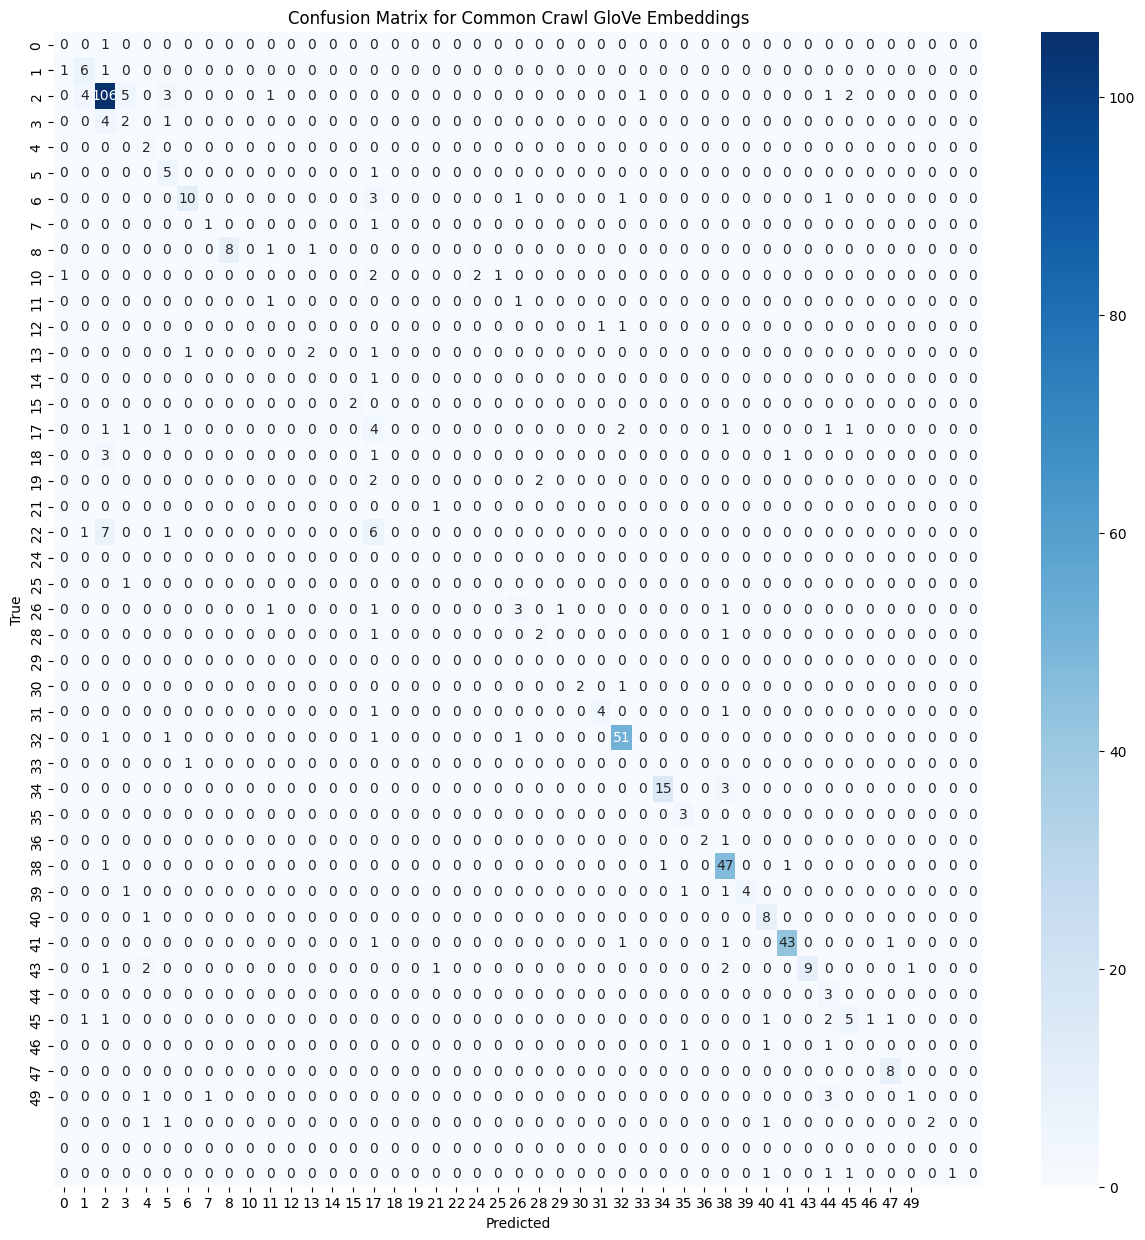


Evaluation Metrics:
Accuracy: 0.7240
F1 Score: 0.7113
Precision: 0.7248
Recall: 0.7240


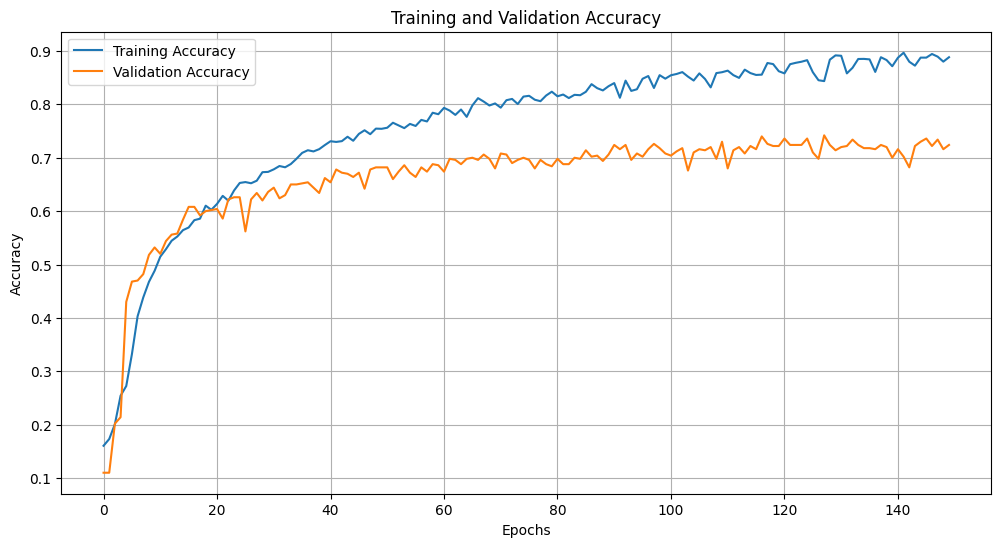

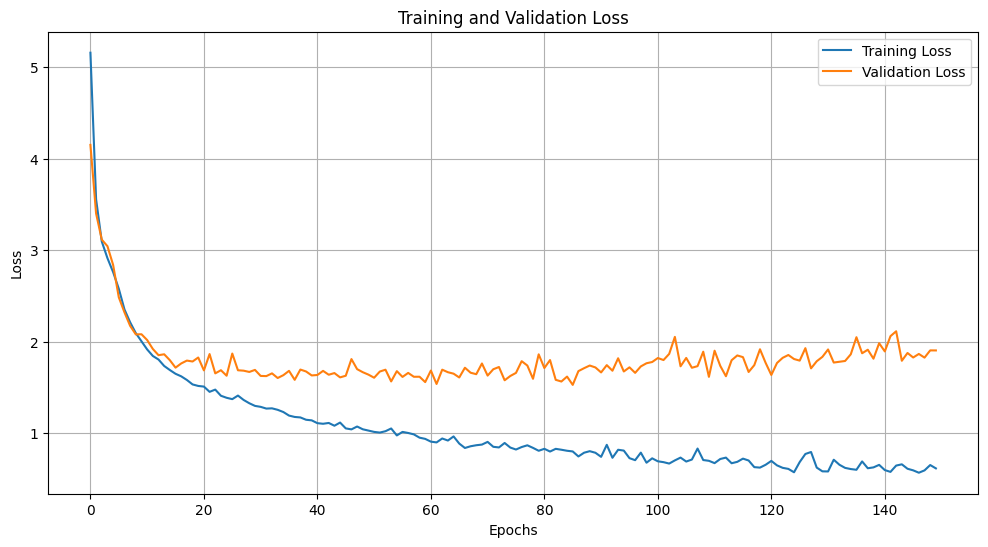

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.callbacks import EarlyStopping

# Assuming create_embedding_matrix and create_model functions are defined elsewhere

# Create the embedding matrix
embedding_dim = 300
embedding_matrix = create_embedding_matrix(embedding_index, tokenizer, embedding_dim=embedding_dim)

# Create and compile the model
model = create_model(embedding_matrix, embedding_dim, max_len)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_padded, y_train, epochs=150, batch_size=64, 
                    validation_data=(X_test_padded, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predictions and metrics
y_pred = np.argmax(model.predict(X_test_padded), axis=1)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix for Common Crawl GloVe Embeddings')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
